# Running the hydronn retrieval

This notebook runs the Hydronn retrieval on the latest GOES 16 observations.

## Dependencies

The following dependencies are required to run this example. The easiest way to install them is to use ``conda``, preferably in a clean environment.


- satpy: See installation instructions [here](https://satpy.readthedocs.io/en/stable/install.html).
- cartopy: See installation instructions [here](https://scitools.org.uk/cartopy/docs/latest/installing.html)


Furthermore, this example uses  the``pansat`` package to download the latest GOES observations. The package can be installed directly from github.

In [10]:
!python -m pip install git+https://github.com/see-geo/pansat
!python -m pip install git+https://github.com/simonpf/hydronn

  Cloning https://github.com/see-geo/pansat to /tmp/pip-req-build-u6mllu7m
  Running command git clone --filter=blob:none --quiet https://github.com/see-geo/pansat /tmp/pip-req-build-u6mllu7m
  Resolved https://github.com/see-geo/pansat to commit 96455b25773f2c82e1fdcd45d95d367cbd517f56
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/simonpf/hydronn to /tmp/pip-req-build-b0o04mgf
  Running command git clone --filter=blob:none --quiet https://github.com/simonpf/hydronn /tmp/pip-req-build-b0o04mgf
  Resolved https://github.com/simonpf/hydronn to commit 046cb5536802ab22a5bb8c762f5d05cf2655d547
  Preparing metadata (setup.py) ... done


  Created wheel for hydronn: filename=hydronn-0.0-py3-none-any.whl size=101645 sha256=4e00bad51bc72a2e72021620eb78d38dfd4b1a2fbf1f9948df5e0adc2db3728c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3q1baqid/wheels/9c/9e/21/6f287144d9e2712c417c064faa06fb18809daf82768503325f
Successfully built hydronn


## Download and load the neural network

In [1]:
from pathlib import Path
import shutil
import urllib

def download_model(model_name):
    """
    Download Hydronn model if not already present in working directory.
    
    Args:
        model_name: The name of the model. Valid choices are
            -'hydronn_2': For the Hydronn 2km retrieval using all input observations.
            -'hydronn_4_all': For the Hydronn 4km retrieval using all input observations.
            -'hydronn_4_ir': For the Hydronn 4km retrieval using only IR observations.
            
    Return:
        pathlib.Path pointing to the downloaded file.
    """
    if not model_name in ["hydronn_2", "hydronn_4_all", "hydronn_4_ir"]:
        raise ValueError("Model name must be one of 'hydronn_2', 'hydronn_4_ir', 'hydronn_4_all'")
    path = Path(f"{model_name}.pckl")
    if not path.exists():
        url = f"http://spfrnd.de/data/{model_name}.pckl"
        with urllib.request.urlopen(url) as response:
            with open(path, "wb") as output:
                shutil.copyfileobj(response, output)
    return path

In [2]:
from quantnn.qrnn import QRNN
model_file = download_model("hydronn_4_all")
hydronn = QRNN.load(model_file)

/home/simonpf/miniconda3/envs/hydronn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download GOES observations

Download most recent GOES observations and load them into a ``GOES16File`` object.

In [3]:
from datetime import datetime, timedelta
from hydronn.data.goes import GOES16File

input_file = GOES16File.download_latest()

Extract observations over Brazil, normalize the inputs, and put them into PyTorch tensors.

In [4]:
retrieval_input = input_file.get_retrieval_input(normalizer=hydronn.model.normalizer)

## Running the retrieval

This function runs the retrieval on the input data. To reduce the memory requirements the processing performed using tiles of size 512 x 256 pixels. If you have a GPU available the retrieval can be sped up by passing ``device='cuda'`` as argument to the function.

In [5]:
from hydronn.retrieval import retrieve
results = retrieve(hydronn, retrieval_input, tile_size=(512, 256), overlap=64)

## Displaying the results

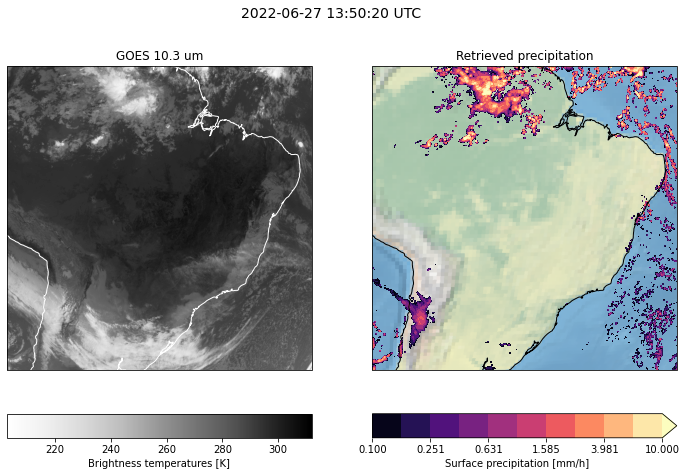

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import numpy as np

# Get area definition
area = input_file.get_area()
crs = area.to_cartopy_crs()
extent = area.area_extent
extent = (extent[0], extent[2], extent[1], extent[3])

f = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 2, height_ratios=[1.0, 0.075])
precip_norm = LogNorm(1e-1, 1e1)

axs = np.array([f.add_subplot(gs[0, i], projection=crs) for i in range(2)])

# GOES 10.3 um observations.
obs_10u = input_file.get_10u()
ax = axs[0]
m = ax.imshow(obs_10u, extent=extent, cmap="Greys")
ax.coastlines(color="white")
ax.set_title("GOES 10.3 um")

ax = f.add_subplot(gs[1, 0])
plt.colorbar(m, label="Brightness temperatures [K]", cax=ax, orientation="horizontal")


# Retrieval results
ax = axs[1]
levels = np.logspace(-1, 1, 11)
m = ax.contourf(results["surface_precip"][0][::-1],
            extent=extent,
            norm=precip_norm,
            levels=levels,
            extend="max",
            cmap="magma")
ax.stock_img()
ax.coastlines()
ax.set_title("Retrieved precipitation")


ax = f.add_subplot(gs[1, 1])
plt.colorbar(m, label="Surface precipitation [mm/h]", cax=ax, orientation="horizontal")

f.suptitle(input_file.start_time.strftime("%Y-%m-%d %H:%M:%S UTC"), fontsize=14);